## Project: Portfolio Management Using Multi-Agent Reinforcement Learning 

## Part 3: Reinfocement Learning Model

- Step 1: Import Libraries and Install Packages
> - Step 1.1: Install required packages if not already installed
> - Step 1.2: Import the necessary libraries
- Step 2: Define Constants
> - Step 2.1: Define start and end dates for training data
> - Step 2.2: Define start and end dates for testing data
- Step 3: Load and Merge Dataframes
> - Step 3.1: Load YahooFinance and sentiment dataframes
> - Step 3.2: Create GDP dataframe
> - Step 3.3: Merge all dataframes into one
- Step 4: Incorporate Technical Indicators
> - Step 4.1: Use historical data to calculate technical indicators
- Step 5: Design Environment Constants
> - Step 5.1: Define environment parameters
> - Step 5.2: Define A2C model parameters
> - Step 5.3: Define PPO model parameters
> - Step 5.4: Define DDPG model parameters
> - Step 5.5: Define timesteps
> - Step 5.6: Define ensemble agent parameters.
- Step 6: Implement Deep Reinforcement Learning Model
> - Step 6.1: Build and train a deep reinforcement learning model using the environment and data
- Step 7: Analyze Results
> - Step 7.1: Calcualte Sharpe ratio
> - Step 7.2: Backtest results
> - Step 7.3: Baseline Statistics
> - Step 7.4: Compare with Index
> - Step 7.5: Vizualise the comparision with Index
- Step 8: Conclusion
> - Step 8.1: Summarize the results and provide insights on the effectiveness of the model

#### Step 1: Import Libraries and Install Packages

> - #### Step 1.1: Install required packages if not already installed

In [1]:
"""
This cell installs the yfinance package if only unable to import, indicating the package is not installed.
This avoids isntalling the packages again.
"""
import importlib

# gym Library
try:
    importlib.import_module('gym')
except ImportError:
    !pip install gym


# swig Library
try:
    importlib.import_module('swig')
except ImportError:
    !pip install swig


# wrds Library
try:
    importlib.import_module('wrds')
except ImportError:
    !pip install wrds


# pyportfolioopt Library
try:
    importlib.import_module('pyportfolioopt')
except ImportError:
    !pip install pyportfolioopt

# condacolab Library
try:
    importlib.import_module('condacolab')
except ImportError:
    !pip install -q condacolab

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import condacolab
condacolab.install()

# !apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

✨🍰✨ Everything looks OK!
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /tmp/pip-req-build-llkf55ph
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /tmp/pip-req-build-llkf55ph
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit 2ed2207c926608d559789624df26ef26682d2e14
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-4rgkj86j/elegantrl_76f05241a98949748f750cac8a09e1b7
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-4rgkj86j/elegantrl_76f05241a98949748f750cac8a09e1b7
  Resolved https://github.com/AI4Finance-Foundation/ElegantRL.git to commit 5db9257f8f

> - #### Step 1.2: Import the necessary libraries

In [3]:
import pandas as pd

%matplotlib inline
from finrl.config_tickers import SP_500_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.agents.stablebaselines3.models import DRLAgent, DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

import pandas_datareader.data as web

import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])



/usr/local/lib/python3.9/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


#### Step 2:  Define the constants.

> - #### Step 2.1: Define start and end dates for training data

In [4]:
TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2017-12-31'

> - #### Step 2.2: Define start and end dates for testing data

In [5]:
TEST_START_DATE = '2018-01-01'
TEST_END_DATE = '2020-12-30'

#### Step 3: Load and Merge Dataframes

In [6]:
!pip install gdown
import gdown
# The link for the data folder in Google drive. 
data_url = "https://drive.google.com/drive/folders/1zQGlgh5kHTXSq7eoyXf6i_uAWYFJ5xzx?usp=share_link"

current_path = os.getcwd() # Get the current working directory.

data_folder_path = os.path.join(os.getcwd(),"genie_data") # Generate data folder path. 

# Check if the folder already exists locally

if not os.path.exists(data_folder_path):
    
    os.makedirs(data_folder_path)
    print(f"Downloading data from Google Drive to: {data_folder_path}")
    gdown.download_folder(data_url,output=data_folder_path, quiet=True, use_cookies=False) # Download the data from Google Drive.
    
else:
    print(f"Directory already exists: {data_folder_path}")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Directory already exists: /content/genie_data


> - #### Step 3.1: Load YahooFinance and sentiment dataframes

In [7]:
yf_df = pd.read_csv('./genie_data/yf-data.csv',index_col='Unnamed: 0')
yf_df["date"] = pd.to_datetime(yf_df["date"])

yf_df


,date,open,high,low,close,volume,tic,day
0,2010-01-04,39.099998,39.419998,38.840000,22.922108,2175500,D,0
1,2010-01-04,11.220000,11.430000,10.950000,9.966131,14482500,DAL,0
2,2010-01-04,5.660000,5.970000,5.650000,4.164575,14901600,KEY,0
3,2010-01-04,25.320000,25.910000,24.930000,19.833185,3811400,LNC,0
4,2010-01-04,15.245000,15.350000,15.120000,9.583809,1332800,LNT,0
...,...,...,...,...,...,...,...,...
28549,2020-12-30,50.520000,51.000000,50.360001,47.424179,563800,LNT,2
28550,2020-12-30,147.470001,147.990005,147.009995,138.462997,2224900,PEP,2
28551,2020-12-30,138.600006,138.919998,137.550003,130.316620,3261400,PG,2
28552,2020-12-30,372.339996,373.100006,371.570007,359.862762,49455300,SPY,2


In [8]:
sentiments_df = pd.read_csv('./genie_data/sentiments_df.csv',index_col='Unnamed: 0')
sentiments_df["date"] = pd.to_datetime(sentiments_df["date"])

sentiments_df

,date,SentimentScore,tic
1036,2005-01-01,0.0,LNC
1003,2005-01-01,0.0,XEL
1762,2005-01-01,0.0,PG
2431,2005-01-01,0.0,D
155,2005-01-01,0.0,ETSY
...,...,...,...
7427,2020-12-31,0.0,KEY
5943,2020-12-31,0.0,ETSY
7021,2020-12-31,0.0,PG
6010,2020-12-31,0.0,ENPH


> - #### Step 3.2: Create GDP dataframe.

In [9]:
gdp = web.DataReader("GDP", 'fred', 2010, 2020)
gdp = gdp.reset_index()

In [10]:
date = pd.date_range(start='2010-01-01', end='2020-12-30')
date_df = pd.DataFrame()
date_df['date'] = date

In [11]:
gdp['date']=pd.to_datetime(gdp['DATE'])
gdp.rename(columns = {'GDP':'gdp'}, inplace = True)
gdp = gdp.drop(['DATE'], axis=1)
gdp_df=gdp.merge(date_df, on='date', how='right')
gdp_df = gdp_df.fillna(method='ffill')
gdp_df = gdp_df.merge(pd.DataFrame({"tic":yf_df.tic.unique()}),how="cross")

 > - #### Step 3.3:  Merge all dataframes into one

In [12]:
df = pd.merge(pd.merge(yf_df, sentiments_df, how='left', left_on=['date','tic'], right_on = ['date','tic']),
              gdp_df, how='left', left_on=['date','tic'], right_on = ['date','tic'])

In [13]:
df

,date,open,high,low,close,volume,tic,day,SentimentScore,gdp
0,2010-01-04,39.099998,39.419998,38.840000,22.922108,2175500,D,0,0.0,14764.611
1,2010-01-04,11.220000,11.430000,10.950000,9.966131,14482500,DAL,0,0.0,14764.611
2,2010-01-04,5.660000,5.970000,5.650000,4.164575,14901600,KEY,0,0.0,14764.611
3,2010-01-04,25.320000,25.910000,24.930000,19.833185,3811400,LNC,0,0.0,14764.611
4,2010-01-04,15.245000,15.350000,15.120000,9.583809,1332800,LNT,0,0.0,14764.611
...,...,...,...,...,...,...,...,...,...,...
41102,2020-12-30,50.520000,51.000000,50.360001,47.424179,563800,LNT,2,0.0,21538.032
41103,2020-12-30,147.470001,147.990005,147.009995,138.462997,2224900,PEP,2,0.0,21538.032
41104,2020-12-30,138.600006,138.919998,137.550003,130.316620,3261400,PG,2,0.0,21538.032
41105,2020-12-30,372.339996,373.100006,371.570007,359.862762,49455300,SPY,2,NaN,21538.032


In [14]:
df["SentimentScore"] = df["SentimentScore"].fillna(0)

In [15]:
df.head(20)

,date,open,high,low,close,volume,tic,day,SentimentScore,gdp
0,2010-01-04,39.099998,39.419998,38.840000,22.922108,2175500,D,0,0.0,14764.611
1,2010-01-04,11.220000,11.430000,10.950000,9.966131,14482500,DAL,0,0.0,14764.611
2,2010-01-04,5.660000,5.970000,5.650000,4.164575,14901600,KEY,0,0.0,14764.611
3,2010-01-04,25.320000,25.910000,24.930000,19.833185,3811400,LNC,0,0.0,14764.611
4,2010-01-04,15.245000,15.350000,15.120000,9.583809,1332800,LNT,0,0.0,14764.611
5,2010-01-04,61.189999,61.520000,60.639999,41.632233,6585900,PEP,0,0.0,14764.611
6,2010-01-04,61.110001,61.310001,60.630001,41.181229,9190800,PG,0,0.0,14764.611
7,2010-01-04,112.370003,113.389999,111.510002,88.117897,118944600,SPY,0,0.0,14764.611
8,2010-01-04,21.379999,21.379999,21.040001,13.396955,2670400,XEL,0,0.0,14764.611
9,2010-01-05,38.860001,39.020000,38.080002,22.639708,2802200,D,1,0.0,14764.611


In [16]:
df.drop_duplicates(subset=['date', 'tic'], inplace=True)

df.shape

(28554, 10)

#### Step 4: Incorporate Technical Indicators.

> - #### Step 4.1: Use historical data to calculate technical indicators

In [17]:
technical_indicators = ['macd', 'rsi_30', 'cci_30', 'dx_30']

In [18]:
fe_pipeline = FeatureEngineer(use_technical_indicator=True, 
                              tech_indicator_list = technical_indicators, 
                              use_turbulence=True, 
                              user_defined_feature = True
                              )

In [19]:
df_processed = fe_pipeline.preprocess_data(df)

Successfully added technical indicators
Successfully added turbulence index
Successfully added user defined features


#### Step 5:  Design Environment constants.

> - #### Step 5.1: Define environment parameters

In [20]:
stock_dimension = len(df_processed.tic.unique())

udfs = 2 # Sentiment Scores, GDP

state_space = 1 + 2 * stock_dimension + len(technical_indicators)*stock_dimension + udfs*stock_dimension

print(f"Stock Dimension: {stock_dimension}, state Space: {state_space}")

Stock Dimension: 9, state Space: 73


In [21]:
technical_indicators.extend(["SentimentScore","gdp"])

In [22]:
# Defining a dictionary containing environment arguments

env_variables = { "hmax": 100,                        # Maximum number of shares that can be traded at a time
                  "buy_cost_pct": 0.001,              # Transaction cost for buying
                  "sell_cost_pct": 0.001,             # Transaction cost for selling
                  "state_space": state_space,         # State space for the environment
                  "tech_indicator_list": technical_indicators,  # List of technical indicators used
                  "action_space": stock_dimension,    # Action space for the environment
                  "reward_scaling": 1e-4,             # Scaling factor for rewards
                  "print_verbosity": 5                # Level of detail for logging during training
                  }

> - #### Step 5.2: Define A2C model parameters

In [23]:
A2C_model_kwargs = {'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0007}

> -  #### Step 5.3: Define PPO model parameters

In [24]:
PPO_model_kwargs = { "ent_coef": 0.01, "n_steps": 2048, "learning_rate": 0.00025, "batch_size": 128 }

> - #### Step 5.4: Define DDPG model parameters

In [25]:
DDPG_model_kwargs = { "buffer_size": 10_000, "learning_rate": 0.0005, "batch_size":64 }

> - #### Step 5.5: Define timesteps

In [26]:
timesteps_dict = { 'a2c': 10_000, 'ppo': 10_000, 'ddpg': 10_000 }

> - #### Step 5.6: Define ensemble agent parameters.

In [27]:
rebalance_window = 63
validation_window = 63

In [28]:
ensemble_agent = DRLEnsembleAgent(initial_amount = 10000,
                                  stock_dim = stock_dimension,
                                  df = df_processed,
                                  train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                                  val_test_period=(TEST_START_DATE,TEST_END_DATE),
                                  rebalance_window=rebalance_window,
                                  validation_window=validation_window,
                                  **env_variables)

#### Step 6: Implement Deep Reinforcement Learning Model

> - #### Step 6.1: Build and train a deep reinforcement learning model using the environment and data

In [29]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs, PPO_model_kwargs, DDPG_model_kwargs, timesteps_dict)

============Start Ensemble Strategy============
turbulence_threshold:  45.85564342289035
======Model training from:  2010-01-01 to  2018-01-02 00:00:00
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0007}
Using cpu device
Logging to tensorboard_log/a2c/a2c_126_1
----------------------------------------
| time/                 |              |
|    fps                | 208          |
|    iterations         | 100          |
|    time_elapsed       | 2            |
|    total_timesteps    | 500          |
| train/                |              |
|    entropy_loss       | -13          |
|    explained_variance | -1.19e-07    |
|    learning_rate      | 0.0007       |
|    n_updates          | 99           |
|    policy_loss        | -0.0751      |
|    reward             | -0.006231971 |
|    std                | 1.03         |
|    value_loss         | 6.47e-05     |
----------------------------------------
---------------------------------------
| time/ 

In [30]:
df_summary

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe
0,126,2018-01-02,2018-04-04,DDPG,-0.344844,-0.285821,-0.200955
1,189,2018-04-04,2018-07-03,A2C,0.333763,0.245514,0.150688
2,252,2018-07-03,2018-10-02,A2C,0.358912,0.124735,0.261753
3,315,2018-10-02,2019-01-03,PPO,-0.221576,-0.150745,-0.225136
4,378,2019-01-03,2019-04-04,DDPG,0.571566,0.381142,0.873514
5,441,2019-04-04,2019-07-05,A2C,0.297377,-0.016631,0.195488
6,504,2019-07-05,2019-10-03,PPO,-0.130224,-0.032059,-0.071943
7,567,2019-10-03,2020-01-03,DDPG,0.065048,-0.091907,0.247086
8,630,2020-01-03,2020-04-03,DDPG,-0.237968,-0.308153,-0.020193
9,693,2020-04-03,2020-07-06,DDPG,0.090045,0.174383,0.336998


#### Step 7: Analyze Results

In [112]:
# Get the datest to which the testing predictions. 
test_dates = df_processed[(df_processed.date > TEST_START_DATE)&(df_processed.date <= TEST_END_DATE)].date.unique()

trade_date_df = pd.DataFrame({'datadate':test_dates}) # Convert the dates to a dataframe

In [113]:
results_list = []
# for every cycle (rebalance_window + validation_window) read the csv files into a dataframe
for i in range(rebalance_window+validation_window, len(test_dates)+1,rebalance_window):
     result_df = pd.read_csv(f'results/account_value_trade_ensemble_{i}.csv')
     results_list.append(result_df)

df_ensemble_results  = pd.concat(results_list, ignore_index=True)  # Create a dataframe to store execution results

> - #### Step 7.1: Calcualte Sharpe ratio

In [114]:
# Calculate Sharpe ratio
sharpe=(252**0.5)*df_ensemble_results.account_value.pct_change(1).mean()/df_ensemble_results.account_value.pct_change(1).std()

print('Sharpe Ratio: ',sharpe)

Sharpe Ratio:  0.8546688049088031


In [115]:
df_validation_dates = trade_date_df[validation_window:].reset_index(drop=True) # Get the stock market dates from historical data
df_ensemble_results = df_ensemble_results.join(df_validation_dates) # Mask the results with the dates.

<Axes: >

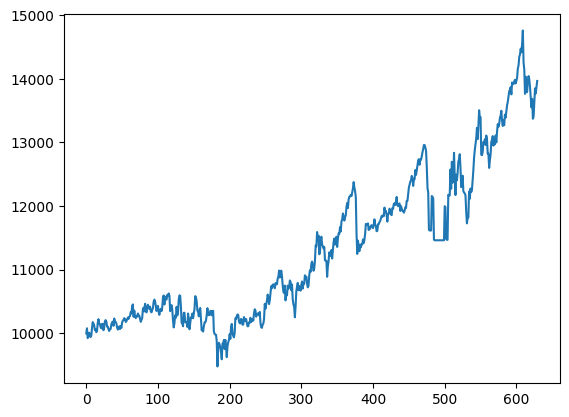

In [116]:
%matplotlib inline
df_ensemble_results.account_value.plot()     # plot the chance in the amount value with time during test period.

> - #### Step 7.2: Backtest results

In [117]:
stats = backtest_stats(account_value=df_ensemble_results)
stats_df = pd.DataFrame(stats)

Annual return          0.142964
Cumulative returns     0.396630
Annual volatility      0.174452
Sharpe ratio           0.854669
Calmar ratio           1.236743
Stability              0.849327
Max drawdown          -0.115597
Omega ratio            1.169602
Sortino ratio          1.200887
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.890179
Daily value at risk   -0.021387
dtype: float64


> - #### Step 7.3: Baseline Statistics

In [118]:
df_index = df.loc[df['tic'] == 'SPY'].sort_values(['date'])

In [119]:
mask = (df_index['date'] > df_ensemble_results.loc[0,'date']) & (df_index['date'] <= df_ensemble_results.loc[len(df_ensemble_results)-1,'date'])
df_index_masked = df_index.loc[mask].reset_index(drop=True)


In [120]:
index_stats = backtest_stats(df_index_masked, value_col_name = 'close')

Annual return          0.121354
Cumulative returns     0.330942
Annual volatility      0.236552
Sharpe ratio           0.604095
Calmar ratio           0.359916
Stability              0.554521
Max drawdown          -0.337173
Omega ratio            1.137069
Sortino ratio          0.825409
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.702057
Daily value at risk   -0.029236
dtype: float64


> - #### Step 7.4: Compare with Index

In [121]:
# Rescale index stocks with begining as 10000

df_index_scaled = pd.DataFrame()

df_index_scaled["date"] = df_ensemble_results["date"]

df_index_scaled["spy"] = df_index_masked['close'] / df_index_masked.iloc[0]['close'] * 10000


In [122]:
df_index_scaled

,date,spy
0,2018-04-04,10000.000000
1,2018-04-05,9777.141321
2,2018-04-06,9825.327421
3,2018-04-09,9981.552869
4,2018-04-10,9929.227721
...,...,...
625,2020-09-25,13196.873815
626,2020-09-28,13125.003128
627,2020-09-29,13224.516675
628,2020-09-30,13309.419390


In [123]:
final_results = pd.merge(df_ensemble_results, df_index_scaled, on ="date", how = "left")[["date","account_value","spy"]]

In [124]:
final_results.set_index("date")

,account_value,spy
date,,
2018-04-04,10000.000000,10000.000000
2018-04-05,10079.479603,9777.141321
2018-04-06,9924.454502,9825.327421
2018-04-09,9957.314686,9981.552869
2018-04-10,10010.884480,9929.227721
...,...,...
2020-09-25,13623.655667,13196.873815
2020-09-28,13849.337685,13125.003128
2020-09-29,13771.108647,13224.516675


> - #### Step 7.5: Vizualise the comparision with Index

<Axes: >

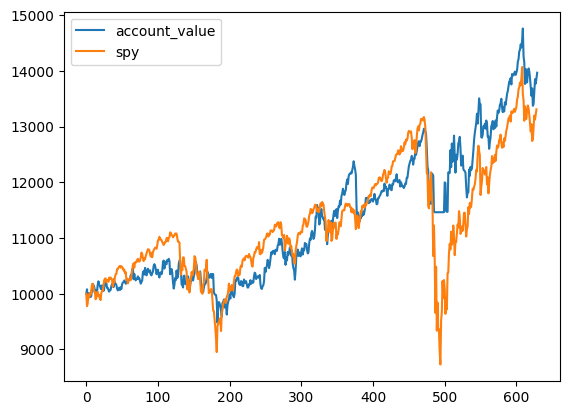

In [125]:
final_results.plot()